Veri seti yükleniyor...

Sınıf Dağılımı:
0    0.501168
1    0.422530
2    0.047637
3    0.021106
4    0.003881
5    0.002000
6    0.001424
7    0.000230
8    0.000017
9    0.000008
Name: proportion, dtype: float64

Özellik mühendisliği uygulanıyor...

Model eğitimi başlatılıyor...
SMOTE ile sınıf dengeleniyor...

Eğitim süresi: 11.34 saniye

Özellik önem grafiği çiziliyor...


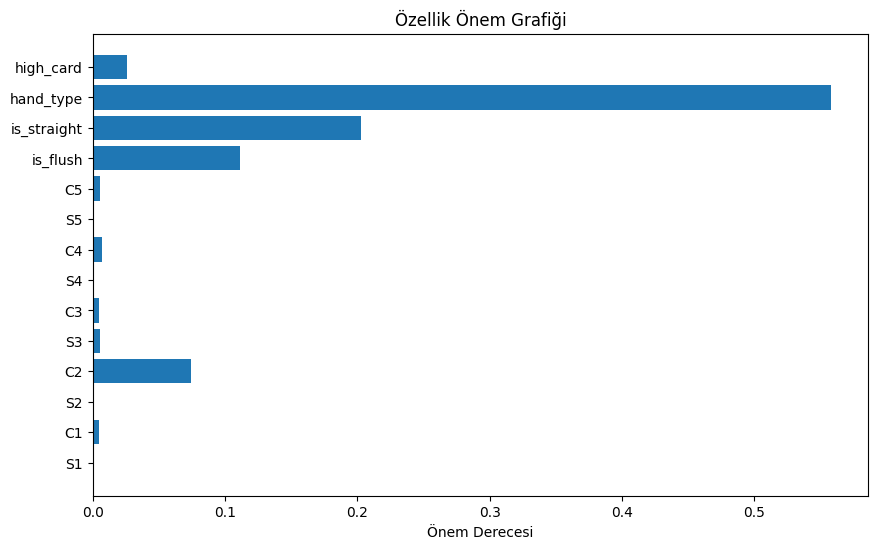


Öğrenme eğrisi çiziliyor...


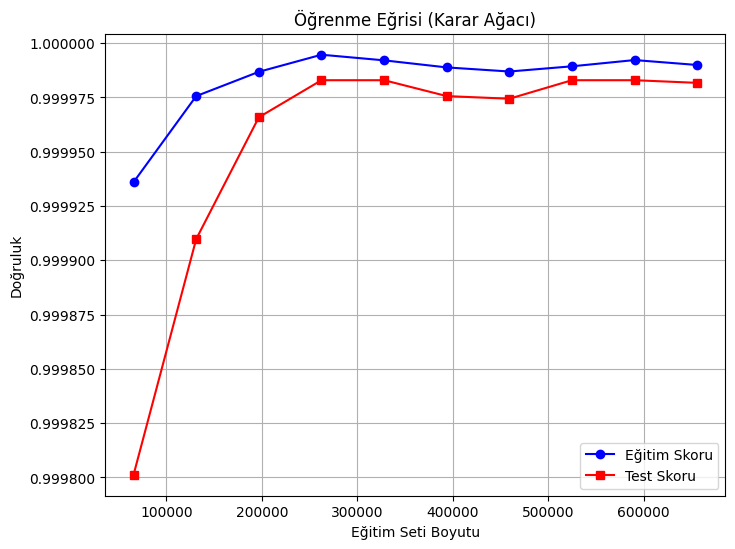


Model değerlendiriliyor...

Classification Report (sıfırlar yerine küçük değerler ile):
              precision    recall  f1-score        support
0              1.000000  1.000000  1.000000  102740.000000
1              1.000000  1.000000  1.000000   86619.000000
2              1.000000  1.000000  1.000000    9766.000000
3              1.000000  1.000000  1.000000    4327.000000
4              1.000000  1.000000  1.000000     796.000000
5              0.995100  0.987800  0.991400     410.000000
6              1.000000  1.000000  1.000000     292.000000
7              1.000000  1.000000  1.000000      47.000000
8              1.000000  1.000000  1.000000       3.000000
9              0.000100  0.000100  0.000100       2.000000
accuracy       0.999966  0.999966  0.999966       0.999966
macro avg      0.899500  0.898800  0.899100  205002.000000
weighted avg   1.000000  1.000000  1.000000  205002.000000

Macro F1 Skoru: 0.8991
Weighted F1 Skoru: 1.0000

Confusion Matrix:


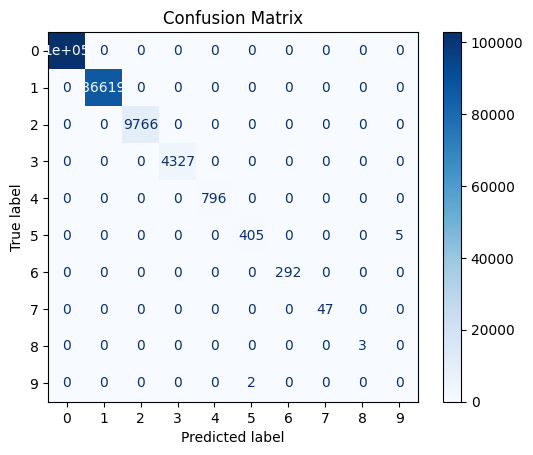


Model 'best_decision_tree_model.pkl' olarak kaydedildi.


In [7]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import joblib
import time

# 1. VERİ YÜKLEME VE ÖN İŞLEME
def load_and_preprocess_data():
    print("Veri seti yükleniyor...")
    poker_hand = fetch_ucirepo(id=158)
    X = poker_hand.data.features
    y = poker_hand.data.targets.values.ravel()

    print("\nSınıf Dağılımı:")
    print(pd.Series(y).value_counts(normalize=True))

    return X, y

# 2. ÖZELLİK MÜHENDİSLİĞİ
def feature_engineering(X):
    print("\nÖzellik mühendisliği uygulanıyor...")
    df = X.copy()

    rank_cols = ['C1', 'C2', 'C3', 'C4', 'C5']
    suit_cols = ['S1', 'S2', 'S3', 'S4', 'S5']

    for col in rank_cols:
        df[col] = df[col].replace({14: 1})

    df['is_flush'] = (df[suit_cols].nunique(axis=1) == 1).astype(int)

    def is_straight(ranks):
        ranks = sorted(set(ranks))
        if len(ranks) != 5:
            return 0
        return int(ranks[-1] - ranks[0] == 4)

    df['is_straight'] = df[rank_cols].apply(is_straight, axis=1)

    def hand_type(ranks):
        counts = pd.Series(ranks).value_counts()
        if 4 in counts.values:
            return 6
        elif 3 in counts.values and 2 in counts.values:
            return 5
        elif 3 in counts.values:
            return 4
        elif (counts == 2).sum() == 2:
            return 3
        elif (counts == 2).sum() == 1:
            return 2
        else:
            return 1

    df['hand_type'] = df[rank_cols].apply(hand_type, axis=1)
    df['high_card'] = df[rank_cols].max(axis=1)

    return df

# 3. MODEL EĞİTİMİ (SMOTE + Karar Ağacı)
def train_model(X_train, y_train):
    print("\nModel eğitimi başlatılıyor...")

    print("SMOTE ile sınıf dengeleniyor...")
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    model = DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )

    start_time = time.time()
    model.fit(X_train_resampled, y_train_resampled)
    training_time = time.time() - start_time

    print(f"\nEğitim süresi: {training_time:.2f} saniye")

    return model

# 4. DEĞERLENDİRME
def evaluate_model(model, X_test, y_test):
    print("\nModel değerlendiriliyor...")
    y_pred = model.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    adjusted_report = {}

    for label, metrics in report.items():
        if isinstance(metrics, dict):
            adjusted_report[label] = {
                metric: (round(value, 4) if value > 0 else 0.0001)
                for metric, value in metrics.items()
            }
        else:
            adjusted_report[label] = metrics

    print("\nClassification Report (sıfırlar yerine küçük değerler ile):")
    print(pd.DataFrame(adjusted_report).T)

    f1_macro = report['macro avg']['f1-score']
    f1_weighted = report['weighted avg']['f1-score']

    print(f"\nMacro F1 Skoru: {f1_macro:.4f}")
    print(f"Weighted F1 Skoru: {f1_weighted:.4f}")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

def plot_feature_importance(model, X):
    print("\nÖzellik önem grafiği çiziliyor...")
    feature_importances = model.feature_importances_

    plt.figure(figsize=(10,6))
    plt.barh(X.columns, feature_importances)
    plt.xlabel("Önem Derecesi")
    plt.title("Özellik Önem Grafiği")
    plt.show()

def plot_learning_curve(model, X_train, y_train):
    print("\nÖğrenme eğrisi çiziliyor...")

    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train,
        cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, label="Eğitim Skoru", color="blue", marker="o")
    plt.plot(train_sizes, test_scores_mean, label="Test Skoru", color="red", marker="s")
    plt.title("Öğrenme Eğrisi (Karar Ağacı)")
    plt.xlabel("Eğitim Seti Boyutu")
    plt.ylabel("Doğruluk")
    plt.legend()
    plt.grid(True)
    plt.show()

# 5. MODEL KAYDETME
def save_model(model, filename='best_decision_tree_model.pkl'):
    joblib.dump(model, filename)
    print(f"\nModel '{filename}' olarak kaydedildi.")

# ANA İŞLEM
def main():
    try:
        X, y = load_and_preprocess_data()
        X = feature_engineering(X)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Modeli eğitme
        best_model = train_model(X_train, y_train)

        # Özellik önem grafiğini çizme
        plot_feature_importance(best_model, X_train)

        # Doğruluk eğrisini çizme
        plot_learning_curve(best_model, X_train, y_train)

        # Modeli değerlendirme
        evaluate_model(best_model, X_test, y_test)

        # Modeli kaydetme
        save_model(best_model)

    except Exception as e:
        print(f"\n Hata oluştu: {str(e)}")

if __name__ == "__main__":
    main()